In [208]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Task 1

## Initialize parameters

In [209]:
Li = 9.5 # sea ice latent heat of fusion [W/(m^3 years)]
coHo = 6.3 # heat capacity of OML [W/(m^2 years K)]
zeta = 0.7 # sea ice thermodynamic scale thickness [m]

## Atmosphere/ice interface
a_bar   = .56  # co-albedo, ice/ocean average
delta_a = .48  # difference of ice/ocean co-albedos
h_a     = .5   # smoothness of albedo transition, [m]

S_m = 100  # short-wave (solar) flux: annual mean [W/m^2]
S_a = 150  # short-wave flux: amplitude of seasonal variation [W/m^2]

L_m = 70   # long-wave flux: annual mean [W/m^2]
L_a = 41   # long-wave flux: seasonal amplitude [W/m^2]
phi = 0.15 # phase shift: summer solstice - peak longwave forcing [years]
p   = 1  # period of seasonal forcing term [years]

B = 2.83 # net surface flux per surface degree [W/(m^2 K)]

## Ice/ocean interface
F_b = 0 # heat flux at bottom

## Integrate ODE for enthalpy

First we define the following helper functions.

In [212]:
# Returns the time-dependent forcing term A.
def A(E, t, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, L_a, p, phi):
    return ((a_bar + delta_a/2*np.tanh(E/(Li*h_a)))*(S_m -S_a*np.cos(2*np.pi*t/p)) - L_m + L_a*np.cos(2*np.pi*(t-phi)/p))

# To recover surface temperature from enthalpy.
def surface_temp(E, coHo, A, B, Li, zeta):
    if E >= 0:
        return E/coHo
    elif E < 0 and A >= 0:
        return 0
    else:
        return A/B*((1-zeta*Li/E)**(-1))

# computes the right-hand side of the ODE for enthalpy
def rhs(E, t, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, L_a, p, phi, 
        coHo, B, zeta, F_b):
    return (A(E, t, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, L_a, p, phi) 
            - B*surface_temp(E, coHo, a, B, Li, zeta) + F_b)

    

Now, evolve enthalpy according to $\frac{dE}{dt} = f(t,E)$ where the forcing is given by $f(t,E) = A - B T(E) + F_b$. The departure from surface temperature, $T$, is given in terms of the enthalpy above.

In [214]:
res = 12*100 # time resolution
t_max = 50
t = np.linspace(0,t_max,res) # integrate over 50 years, with monthly grid spacing

E_0w = 100 # initial condition for enthalpy [J/m^2]
E_0c = -100 # the cold case.

In [215]:
solw = odeint(rhs, E_0w, t, args=(a_bar, delta_a, h_a, Li, S_m, S_a, L_m, 
                                 L_a, p, phi, coHo, B, zeta, F_b))
solc = odeint(rhs, E_0c, t, args=(a_bar, delta_a, h_a, Li, S_m, S_a, L_m, 
                                 L_a, p, phi, coHo, B, zeta, F_b))

## Plotting the results

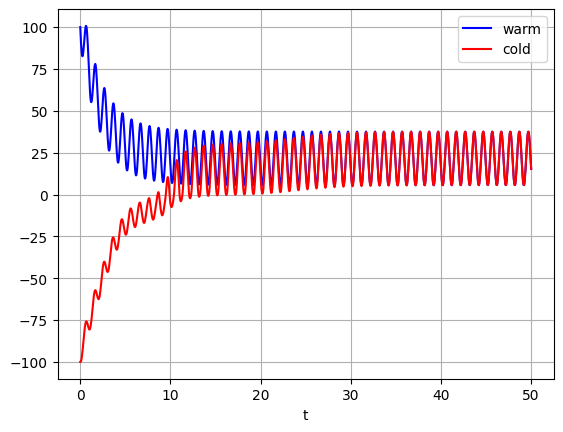

In [216]:
plt.plot(t, solw[:, 0], 'b', label='warm')
plt.plot(t, solc[:, 0], 'r', label='cold')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

# Task 2

We define a new function $A2$ which includes an additional argument to represent loss of long-wave radiation via the forcing term $-X$:

In [217]:
def A2(E, t, X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, L_a, p, phi):
    return ((a_bar + delta_a/2*np.tanh(E/(Li*h_a)))*(S_m -S_a*np.cos(2*np.pi*t/p)) 
            - L_m - X + L_a*np.cos(2*np.pi*(t-phi)/p))

def rhs2(E, t, X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, L_a, p, phi, 
        coHo, B, zeta, F_b):
    return (A2(E, t, X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, L_a, p, phi) 
            - B*surface_temp(E, coHo, a, B, Li, zeta) + F_b)

In [232]:
X = 5 # in [W/m^2]
solw = odeint(rhs2, E_0w, t, args=(X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, 
                                 L_a, p, phi, coHo, B, zeta, F_b))
solc = odeint(rhs2, E_0c, t, args=(X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, 
                                 L_a, p, phi, coHo, B, zeta, F_b))

The plot below shows the divergence in long-term averages of enthalpy in the two cases for $X=5$; the results for $X = 10$ were qualitatively similar to the model without climate forcing in Task 1.

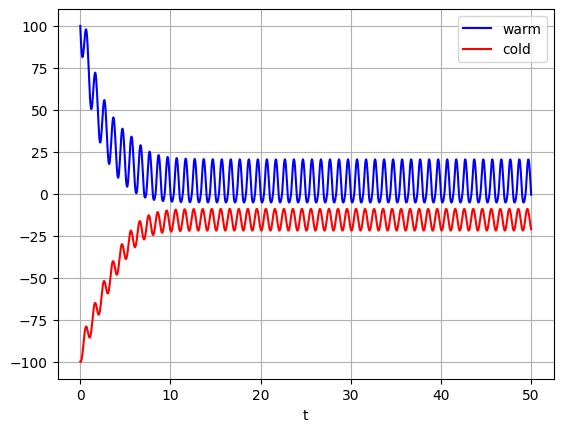

In [233]:
plt.plot(t, solw[:, 0], 'b', label='warm')
plt.plot(t, solc[:, 0], 'r', label='cold')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

# Task 3


In [234]:
solw = []
solc = []

# summer max and winter min for warm initial condition
Emax_w = []
Emin_w = []

# summer max and winter min for cold initial condition
Emax_c = []
Emin_c = []

# consider only 'late' times once enthalpies have converged.    
t_late = np.where(t>20) 

for X in np.linspace(0,20,40):
    sol1 = odeint(rhs2, E_0w, t, args=(X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, 
                                 L_a, p, phi, coHo, B, zeta, F_b))
    sol2 = odeint(rhs2, E_0c, t, args=(X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, 
                                 L_a, p, phi, coHo, B, zeta, F_b))
    solw.append(sol1)
    solc.append(sol2)
    
    Emax_w.append(np.max(sol1[t_late]))
    Emin_w.append(np.min(sol1[t_late]))
    
    Emax_c.append(np.max(sol2[t_late]))
    Emin_c.append(np.min(sol2[t_late]))


Emax_w = np.array(Emax_w)
Emin_w = np.array(Emin_w)
Emax_c = np.array(Emax_c)
Emin_c = np.array(Emin_c)


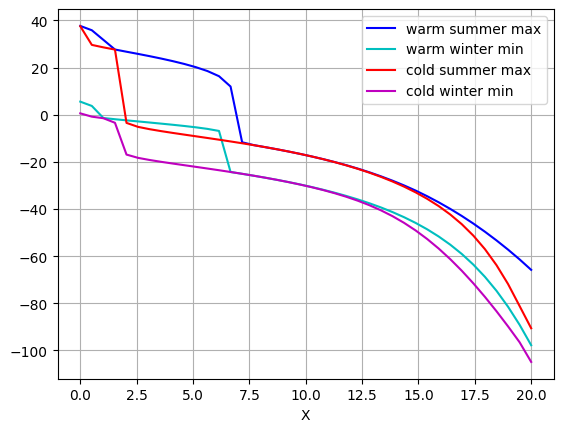

In [246]:
solw = []
solc = []

# summer max and winter min for warm initial condition
Emax_w = []
Emin_w = []

# summer max and winter min for cold initial condition
Emax_c = []
Emin_c = []

# consider only 'late' times once enthalpies have converged.    
t_late = np.where(t>20) 

for X in np.linspace(0,20,40):
    sol1 = odeint(rhs2, E_0w, t, args=(X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, 
                                 L_a, p, phi, coHo, B, zeta, F_b))
    sol2 = odeint(rhs2, E_0c, t, args=(X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, 
                                 L_a, p, phi, coHo, B, zeta, F_b))
    solw.append(sol1)
    solc.append(sol2)
    
    Emax_w.append(np.max(sol1[t_late]))
    Emin_w.append(np.min(sol1[t_late]))
    
    Emax_c.append(np.max(sol2[t_late]))
    Emin_c.append(np.min(sol2[t_late]))


Emax_w = np.array(Emax_w)
Emin_w = np.array(Emin_w)
Emax_c = np.array(Emax_c)
Emin_c = np.array(Emin_c)


# Task 4
Plotted below is the same set of min and max enthalpies, but for varying values of $h_\alpha = 2^{-3} , \ldots, 2^{2}$. As $h_\alpha$ increases, more external forcing is required to ensure a regime where there is only one stable state; for smaller values, the late-time averages of enthalpy depend on the system's history, i.e., on the initial values. 

In [250]:
# range over h values greater than zero; repeat plots from task 3
Emax_w = []
Emin_w = []
Emax_c = []
Emin_c = []

for h_a in 2**(np.linspace(-3,2)):
    solw = []
    solc = []

    # summer max and winter min for warm initial condition
    max_w = []
    min_w = []

    # summer max and winter min for cold initial condition
    max_c = []
    min_c = []

    # consider only 'late' times once enthalpies have converged.    
    t_late = np.where(t>20) 

    for X in np.linspace(0,20,20):
        sol1 = odeint(rhs2, E_0w, t, args=(X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, 
                                     L_a, p, phi, coHo, B, zeta, F_b))
        sol2 = odeint(rhs2, E_0c, t, args=(X, a_bar, delta_a, h_a, Li, S_m, S_a, L_m, 
                                     L_a, p, phi, coHo, B, zeta, F_b))
        solw.append(sol1)
        solc.append(sol2)

        max_w.append(np.max(sol1[t_late]))
        min_w.append(np.min(sol1[t_late]))

        max_c.append(np.max(sol2[t_late]))
        min_c.append(np.min(sol2[t_late]))


    Emax_w.append(np.array(max_w))
    Emin_w.append(np.array(min_w))
    Emax_c.append(np.array(max_c))
    Emin_c.append(np.array(min_c))



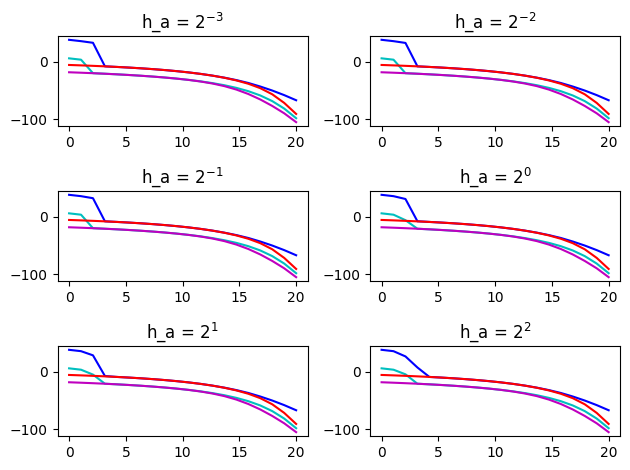

In [259]:
X = np.linspace(0,20,20)
fig, axs = plt.subplots(3, 2)
axs[0, 0].plot(X, Emax_w[0], 'b', label='warm summer max')
axs[0, 0].plot(X, Emin_w[0], 'c', label='warm winter min')
axs[0, 0].plot(X, Emax_c[0], 'r', label='cold summer max')
axs[0, 0].plot(X, Emin_c[0], 'm', label='cold winter min')
axs[0, 0].set_title("h_a = $2^{-3}$")
axs[0, 1].plot(X, Emax_w[1], 'b', label='warm summer max')
axs[0, 1].plot(X, Emin_w[1], 'c', label='warm winter min')
axs[0, 1].plot(X, Emax_c[1], 'r', label='cold summer max')
axs[0, 1].plot(X, Emin_c[1], 'm', label='cold winter min')
axs[0, 1].set_title("h_a = $2^{-2}$")
axs[1, 0].plot(X, Emax_w[2], 'b', label='warm summer max')
axs[1, 0].plot(X, Emin_w[2], 'c', label='warm winter min')
axs[1, 0].plot(X, Emax_c[2], 'r', label='cold summer max')
axs[1, 0].plot(X, Emin_c[2], 'm', label='cold winter min')
axs[1, 0].set_title("h_a = $2^{-1}$")
axs[1, 1].plot(X, Emax_w[3], 'b', label='warm summer max')
axs[1, 1].plot(X, Emin_w[3], 'c', label='warm winter min')
axs[1, 1].plot(X, Emax_c[3], 'r', label='cold summer max')
axs[1, 1].plot(X, Emin_c[3], 'm', label='cold winter min')
axs[1, 1].set_title("h_a = $2^{0}$")
axs[2, 0].plot(X, Emax_w[4], 'b', label='warm summer max')
axs[2, 0].plot(X, Emin_w[4], 'c', label='warm winter min')
axs[2, 0].plot(X, Emax_c[4], 'r', label='cold summer max')
axs[2, 0].plot(X, Emin_c[4], 'm', label='cold winter min')
axs[2, 0].set_title("h_a = $2^{1}$")
axs[2, 1].plot(X, Emax_w[5], 'b', label='warm summer max')
axs[2, 1].plot(X, Emin_w[5], 'c', label='warm winter min')
axs[2, 1].plot(X, Emax_c[5], 'r', label='cold summer max')
axs[2, 1].plot(X, Emin_c[5], 'm', label='cold winter min')
axs[2, 1].set_title("h_a = $2^{2}$")
fig.tight_layout()